In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
import cv2
import os
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
    
AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
#############点云转体素####################
def voxel_transform(point_cloud, leaf_size, x_max, y_max, z_max, random=False):
    # 计算边界点
    """
    x_min, y_min, z_min = np.amin(point_cloud, axis=0) #计算x y z 三个维度的最值
    x_max, y_max, z_max = np.amax(point_cloud, axis=0)
    """
    x_min = 0
    y_min = 0
    z_min = 0
    # 计算 voxel grid维度
    Dx = (x_max - x_min)//leaf_size + 1
    Dy = (y_max - y_min)//leaf_size + 1
    Dz = (z_max - z_min)//leaf_size + 1
    #print("Dx x Dy x Dz is {} x {} x {}".format(Dx, Dy, Dz))
    
    #建立包络空间
    filtered_points = np.zeros(shape=(int(Dx),int(Dy),int(Dz),1))
 
    # 计算每个点的voxel索引
    for i in range(len(point_cloud)):
        hx = int((point_cloud[i][0] - x_min)//leaf_size)
        hy = int((point_cloud[i][1] - y_min)//leaf_size)
        hz = int((point_cloud[i][2] - z_min)//leaf_size)
        filtered_points[hx][hy][hz][0]=1
        
    return  filtered_points
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Vox_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            ####点云转体素
            temp_Vox = voxel_transform(temp_point_cloud, leaf_size=0.5,x_max=51,y_max=51,z_max=10, random=False)

            Vox_small.append(temp_Vox)
    
    return Vox_small
####################原始图像拆分子点云集########################################
PointCloud_new =np.zeros((1,103,103,21,1))
#制作Ground truth
Y_Data=np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0) or (i==1):
        temp2 = np.full((len(temp),12),AC13)
    elif (i==2) or (i==3):
        temp2 = np.full((len(temp),12),AC16)
    elif (i==4) or (i==5) or (i==6) or (i==7):
        temp2 = np.full((len(temp),12),UT5)
    elif (i==8) or (i==9):
        temp2 = np.full((len(temp),12),SMA13)
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10) 
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
    #print(np.array(Y_Data).shape)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
PointCloud_new = np.delete(PointCloud_new, 1, 0)#把第一行0删掉
PointCloud_new =np.array(PointCloud_new)
print(Y_Data.shape)
print(PointCloud_new.shape)

(1579, 12)
(1579, 103, 103, 21, 1)


In [8]:
#### 数据集1579分，切分为1379训练 200测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X_Data = []
Train_Y_Data = []
for i in range(1379):
    Train_X_Data.append(PointCloud_new[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X_Data = []
Test_Y_Data = []
for i in range(1379,1579):
    Test_X_Data.append(PointCloud_new[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X_Data = np.array(Train_X_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X_Data = np.array(Test_X_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X_Data.shape)
print(Train_Y_Data.shape)
print(Test_X_Data.shape)
print(Test_Y_Data.shape)

(1379, 103, 103, 21, 1)
(1379, 12)
(200, 103, 103, 21, 1)
(200, 12)


In [4]:
#googlenet
class Inception(tf.keras.layers.Layer):
    def __init__(self,c1, c2, c3, c4):
        super().__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = tf.keras.layers.Conv3D(c1, kernel_size=1, activation='relu', padding='same')
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = tf.keras.layers.Conv3D(c2[0], kernel_size=1, padding='same', activation='relu')
        self.p2_2 = tf.keras.layers.Conv3D(c2[1], kernel_size=3, padding='same',
                              activation='relu')
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = tf.keras.layers.Conv3D(c3[0], kernel_size=1, padding='same', activation='relu')
        self.p3_2 = tf.keras.layers.Conv3D(c3[1], kernel_size=5, padding='same',
                              activation='relu')
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = tf.keras.layers.MaxPool3D(pool_size=3, padding='same', strides=1)
        self.p4_2 = tf.keras.layers.Conv3D(c4, kernel_size=1, padding='same', activation='relu')
        
        self.BN = tf.keras.layers.BatchNormalization()

    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        p5 = tf.concat([p1, p2, p3, p4], axis=-1)  # 在通道维上连结输出
        p6 = self.BN(p5)
        return p6

def GoogleNet(num_classes):
    b1 = tf.keras.models.Sequential()
    b1.add(tf.keras.layers.Conv3D(64, kernel_size=7, strides=2, padding='same', activation='relu'))
    b1.add(tf.keras.layers.MaxPool3D(pool_size=3, strides=2, padding='same'))
    
    b2 = tf.keras.models.Sequential()
    b2.add(tf.keras.layers.Conv3D(64, kernel_size=1, padding='same', activation='relu'))
    b2.add(tf.keras.layers.Conv3D(192, kernel_size=3, padding='same', activation='relu'))
    b2.add(tf.keras.layers.MaxPool3D(pool_size=3, strides=2, padding='same'))
    
    b3 = tf.keras.models.Sequential()
    b3.add(Inception(64, (96, 128), (16, 32), 32))
    b3.add(Inception(128, (128, 192), (32, 96), 64))
    b3.add(tf.keras.layers.MaxPool3D(pool_size=3, strides=2, padding='same'))
    
    b4 = tf.keras.models.Sequential()
    b4.add(Inception(192, (96, 208), (16, 48), 64))
    b4.add(Inception(160, (112, 224), (24, 64), 64))
    b4.add(Inception(128, (128, 256), (24, 64), 64))
    b4.add(Inception(112, (144, 288), (32, 64), 64))
    b4.add(Inception(256, (160, 320), (32, 128), 128))
    b4.add(tf.keras.layers.MaxPool3D(pool_size=3, strides=2, padding='same'))
    
    b5 = tf.keras.models.Sequential()
    b5.add(Inception(256, (160, 320), (32, 128), 128))
    b5.add(Inception(384, (192, 384), (48, 128), 128))
    b5.add(tf.keras.layers.GlobalAvgPool3D())
    b5.add(tf.keras.layers.Dense(256,activation='relu'))
    b5.add(tf.keras.layers.Dense(256,activation='relu'))

    net = tf.keras.models.Sequential([b1, b2, b3, b4, b5, tf.keras.layers.Dense(num_classes,activation='relu')])
    return net

In [5]:
Batch_size=8
model = GoogleNet(num_classes=12)
model.build(input_shape=(None,103, 103, 21, 1))
model.summary()
lr=1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Callback = tf.keras.callbacks.ModelCheckpoint("Vox_GoogleNet.h5", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=model.fit(x=Train_X_Data,y=Train_Y_Data,batch_size=Batch_size,epochs =200, validation_split=0.2, callbacks=Callback)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 26, 26, 6, 64)     22016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 13, 13, 3, 192)    336128    
_________________________________________________________________
sequential_2 (Sequential)    (None, 7, 7, 2, 480)      1577328   
_________________________________________________________________
sequential_3 (Sequential)    (None, 4, 4, 1, 832)      6888080   
_________________________________________________________________
sequential_4 (Sequential)    (None, 256)               6095856   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 14,922,492
Trainable params: 14,911,516
Non-trainable params: 10,976
_____________________________________

138/138 [==============================] - 8s 60ms/step - loss: 0.5069 - val_loss: 0.3694- ETA: 2
Epoch 35/200
138/138 [==============================] - 8s 61ms/step - loss: 0.7552 - val_loss: 1.8164TA: 3s - - E - ETA: 1s - loss: 0 - ETA: 1s - los - ETA: 0s - 
Epoch 36/200
138/138 [==============================] - 8s 58ms/step - loss: 0.5810 - val_loss: 1.5390 ETA: 0s - loss: 0 - ETA: 0s - loss: 0.57 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.57 - ETA: 0s - loss: 0.57
Epoch 37/200
138/138 [==============================] - 8s 58ms/step - loss: 0.6600 - val_loss: 0.4742A: 6s - loss: 0 - ETA: 6s - los - ETA: 5s - loss: 0 - ETA: 5s - loss: 0 - ETA: 5s - loss: 0.78 - ETA: 5s - ETA: 4s - l - ETA: 3s - loss: 0.7 - ETA: 3s - loss: - ETA: 3s - l - ETA: 2s - loss: 0 - ETA: 2s - loss: 0.700 - ETA: 2s - loss: 0 - ETA: 2s - loss: 0.6 - ETA: 1s - loss: 0.69 - ETA - ETA: 0
Epoch 38/200
138/138 [==============================] - 8s 58ms/step - loss: 0.5523 - val_loss: 0.4378 - loss: 0.65 - ETA: 5s

138/138 [==============================] - 8s 58ms/step - loss: 0.4375 - val_loss: 0.2664ss: 0.4 - ETA: 4s - los - ETA: 4s - ETA: 3s - loss - ETA: 3s - loss - ETA: 2s - loss: 0.4 - - ETA: 1s - loss: 0.43 - ETA: 1s - loss: 0.4 - ETA: 0s - loss:  - ETA: 0s - loss: 0.4 - ETA: 0s - los
Epoch 73/200
138/138 [==============================] - 8s 58ms/step - loss: 0.3701 - val_loss: 0.2700ETA: 6s - loss: 0.33 - ETA: 5s -  - ETA: 4s - los - ETA: 4s - l - ETA: 3s - loss:  - ETA: 3s -  - ETA: 2s - loss: 0.36 - ETA: 2s - loss:  - ETA: 2s - l - ETA: 1s - loss: 0 - ETA: 1s - loss: 0 - ETA: 1s - loss - ETA: 0s - l - ETA: 0s - loss: 0.
Epoch 74/200
138/138 [==============================] - 8s 58ms/step - loss: 0.3742 - val_loss: 0.2843.334 - ETA: 5s - loss: 0.3 - ETA: 5s - - ETA: 4s - lo - ETA: 2s - loss: 0.362 - ETA: 2s - lo - ETA: 2s - loss: 0.3 - ETA: 2s - l - ETA: 1s - ETA: 0s - 
Epoch 75/200
138/138 [==============================] - 8s 58ms/step - loss: 0.3563 - val_loss: 0.29116s -  - ETA: 5s

138/138 [==============================] - 8s 58ms/step - loss: 0.3561 - val_loss: 0.2983- l - ETA: 5s - lo - ETA: 5s - los - ETA: 4s -  - ETA: 4s - loss - ETA: 3s - loss  - ETA: 2s - loss: - ETA: 1s - lo - ETA: 1s - loss: 0.3 - ETA: 
Epoch 107/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2737 - val_loss: 0.25316s - loss: 0.293 - ET - ETA: 5s - loss: 0 - ETA: 5s - l - ETA - ETA: 3s - loss: 0.2 - ETA: 3s - loss: 0.27 - E - ETA: - ETA: 1s - l - ETA: 0s - 
Epoch 108/200
138/138 [==============================] - 8s 57ms/step - loss: 0.3313 - val_loss: 0.2630- loss:  - ETA: 5s - ETA: 5s - loss - ETA: 4s - loss: 0. - ETA: 4s - loss: 0.34 - ETA: 4s -  - ETA: 3s - loss: 0 - ETA: 3 -
Epoch 109/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2548 - val_loss: 0.2874 - ETA: 2s - ETA: 2s  
Epoch 110/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2938 - val_loss: 0.2702s - ETA: 4s - los - ETA: 3s - los - ETA: 3s - los - ETA: 2s -

138/138 [==============================] - 8s 58ms/step - loss: 0.4338 - val_loss: 0.6428 0s - loss: 0.4 - ETA: 0s - loss: 0 - ETA: 0s - loss: 0.43
Epoch 148/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2902 - val_loss: 0.6998oss - ETA: 3s - loss - ETA: 3s - loss: - ETA:  - ETA: 1s - loss: 0.2 - ETA: 1s - loss: 0.28 - ETA: 1s - loss:
Epoch 149/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2594 - val_loss: 0.5950E - E - ETA: 0s - l
Epoch 150/200
138/138 [==============================] - 8s 58ms/step - loss: 0.6263 - val_loss: 0.4285 ETA:  - ETA: 2s  - ETA: 0s 
Epoch 151/200
138/138 [==============================] - 8s 58ms/step - loss: 0.3238 - val_loss: 0.4369 - loss: 0.26 - ETA: 4s - los -  - ETA: 3s  - ETA: 2 - ETA: 1s - loss: 0.314 - ETA: 1s - loss: - ETA: 1s - los - ETA: 0
Epoch 152/200
138/138 [==============================] - 8s 58ms/step - loss: 0.4495 - val_loss: 0.3110A: 6s - los - ETA: 4s - loss: 0.6 - ETA: 4s - loss: 0 - ET

138/138 [==============================] - 8s 58ms/step - loss: 0.2539 - val_loss: 0.1795ETA: 6s - loss: 0.239 - ETA: 6s - loss: - ETA: 6s - lo - ETA: 5 - ETA: 4s - loss: - ETA: 4s  - ETA: 3s -  - ETA: 3s - loss: 0 - ETA: 2s - loss: 0.2 - ETA: - ETA: 1s - l - ETA: 1s - los - ETA: 0s - los - ETA: 0s - loss:  - ETA: 0s - loss: 0.253
Epoch 186/200
138/138 [==============================] - 8s 58ms/step - loss: 0.1922 - val_loss: 0.1803: 0 -  - ETA: 4s - loss: 0 - ETA: 4 - ETA: 3s -  - ETA: 2s - los - ETA: 2s - loss: - ETA: 1s - loss - ETA: 1s - loss: 0.18 - ETA: 1s - ETA: 0s - loss: 0 - ETA: 0s - loss: 0
Epoch 187/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2270 - val_loss: 0.2425- ETA:  - ETA: 5s - los - ETA: - ETA: 2s - loss - ETA: 2s - loss - ETA: 0s - loss: 0.2 - ETA: 0s - loss: 0.22 - ETA: 0s - lo
Epoch 188/200
138/138 [==============================] - 8s 58ms/step - loss: 0.2549 - val_loss: 0.2199s: 0.241 - ETA: 4s - loss: 0.24 - ETA: 4s - loss: 0 - ETA: -

In [6]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/GoogleNet_conv3D_loss.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save() 

7/7 [==============================] - 1s 34ms/step - loss: 0.1625


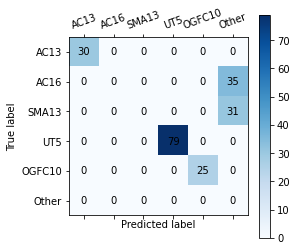

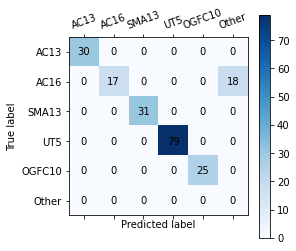

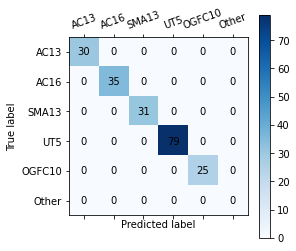

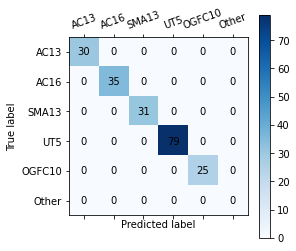

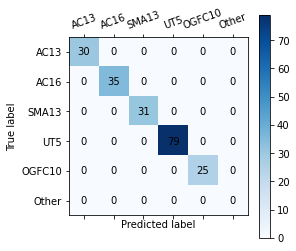

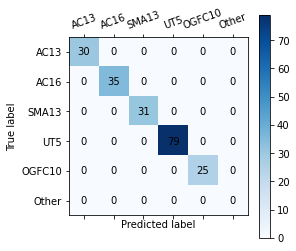

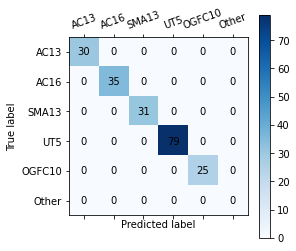

In [9]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

Batch_size=8
model = GoogleNet(num_classes=12)
model.build(input_shape=(None,103, 103, 21, 1))
lr=1e-3
model.load_weights("Vox_GoogleNet.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
model.evaluate(Test_X_Data,Test_Y_Data)
Thr_list = [0.1,0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X_Data)):
        R,P=identification(model(np.array(Test_X_Data[i])[np.newaxis,...])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result, labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Blues) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/GoogleNet_conv3D'+str(Thr)+'.png',dpi=600)#保存图片
    plt.show()